# Deterministic Model for recombination 

In [282]:
from __future__ import division, print_function # Imports from __future__ since we're running Python 2
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline
from scipy.integrate import odeint
from scipy.integrate import ode

In [283]:
#to have [R2]T reach 2000 instead of 20
k_smr = 24.67
#k_smr = 0

k_sr = 15
k_2r = 50
k_Neg_2r = 1e-3
k_ry = 960
k_Neg_ry = 2.4
k_dr1 = 3e-7
k_Neg_dr1 = 12
k_dr4 = 3e-7
k_Neg_dr4 = 4.8e3
k_s0my = 0.01
k_s1my = 0.5
k_sy = 30
k_p = 0.12
k_Neg_p = 0.1
k_ft = 6e4
k_t = 0.92

lambda_mr = 0.462
lambda_r = 0.2
lambda_i2r2 = 0.2
lambda_r2 = 0.2
lambda_my = 0.462
lambda_y = 0.2
lambda_yiex = 0.2


#rates for t7
k_s0mt7 = 0.01
k_rt7 = 960
k_Neg_rt7 = 2.4
k_dr2 = 3e-7
k_Neg_dr2 = 4.8e3

#rates to be modified；at R = 0, T7_mRNA = 667, T7 = 14673
k_s1mt7 = 148.15
lambda_mt7 = 0.462
k_st7 = 4.4
lambda_t7 = 0.2


#rates for cre
k_s0mcre = 0.01
k_rcre = 960
k_Neg_rcre = 2.4
k_dr3 = 3e-7
k_Neg_dr3 = 4.8e3

k_s1mcre = 28.3
lambda_mcre = 0.462
k_scre = 4.4
lambda_cre = 0.2




#rates for step 2~5
k_1 = 13.2
k_Neg_1 = 3.96
k_2 = 13.8
k_Neg_2 = 0.288
k_3 = 2.4
k_Neg_3 = 13
k_4 = 0.021
k_Neg_4 = 10

#new equations added for indicator 
k_mRFP = 24.67
lambda_mRFP = 0.462
k_RFP = 15
lambda_RFP = 0.2

In [284]:
#plt.ion()
#plt.rcParams['figure.figsize'] = 4, 4

p_total_continuous = []
q_total_continuous = []
cre_continuous = []

s_itself_continuous = []
s_combined_continuous = []

se_continuous = []
se2a_continuous = []
se2b_continuous = []
se3_continuous = []
se4_continuous = []
sc_continuous = []

qe2_continuous = []
qe_continuous = []
q_continuous = []

rfp_continuous = []

In [285]:
def f(y, t):
     mr = y[0]
     r = y[1]
     r2 = y[2]
     oy = y[3]
     ot7 = y[4]
     ocre = y[5]
     i = y[6]   
     i2r2 = y[7]
     my = y[8]
     lac_Y = y[9]
     mt7 = y[10]
     t7 = y[11]
     mcre = y[12]
     cre = y[13]   
     yiex = y[14]

     f0 = k_smr - lambda_mr*mr
     f1 = k_sr*mr - 2*k_2r*r*r + 2*k_Neg_2r*r2 - lambda_r*r
     f2 = k_2r*r*r - k_Neg_2r*r2 - k_rt7*r2*ot7 + k_Neg_rt7*(2.08-ot7) - k_ry*r2*oy + k_Neg_ry*(2.08-oy) - k_rcre*r2*ocre + k_Neg_rcre*(60-ocre) - k_dr1*i*i*r2 + k_Neg_dr1*i2r2 - lambda_r2*r2
     f3 = -k_ry*r2*oy + k_Neg_ry*(2.08-oy) + k_dr4*i*i*(2.08-oy) - k_Neg_dr4*i2r2*oy
     f4 = -k_rt7*r2*ot7 + k_Neg_rt7*(2.08-ot7) + k_dr2*i*i*(2.08-ot7) - k_Neg_dr2*i2r2*ot7
     f5 = -k_rcre*r2*ocre + k_Neg_rcre*(60-ocre) + k_dr3*i*i*(60-ocre) - k_Neg_dr3*i2r2*ocre      
     f6 = -2*k_dr1*r2*i*i + 2*k_Neg_dr1*i2r2 - 2*k_dr2*(2.08-ot7)*i*i + 2*k_Neg_dr2*ot7*i2r2 - 2*k_dr3*(60-ocre)*i*i + 2*k_Neg_dr3*ocre*i2r2 - 2*k_dr4*(2.08-oy)*i*i + 2*k_Neg_dr4*oy*i2r2 + k_ft*yiex + k_t*(iex-i) + 2*lambda_i2r2*i2r2 + lambda_yiex*yiex
     f7 = k_dr1*i*i*r2 - k_Neg_dr1*i2r2 + k_dr2*i*i*(2.08-ot7) - k_Neg_dr2*i2r2*ot7 + k_dr3*i*i*(60-ocre) - k_Neg_dr3*i2r2*ocre + k_dr4*i*i*(2.08-oy) - k_Neg_dr4*i2r2*oy - lambda_i2r2*i2r2
     f8 = k_s0my*(2.08-oy) + k_s1my*oy - lambda_my*my
     f9 = k_sy*my + (k_ft + k_Neg_p)*yiex - k_p*lac_Y*iex - lambda_y*lac_Y
     f10 = k_s0mt7*(2.08-ot7) + k_s1mt7*ot7 - lambda_mt7*mt7    
     f11 = k_st7*mt7 - lambda_t7*t7
     f12 = k_s0mcre*(60-ocre)*t7 + k_s1mcre*ocre*t7 - lambda_mcre*mcre   
     f13 = k_scre*mcre - lambda_cre*cre
     f14 = -(k_ft + k_Neg_p)*yiex + k_p*lac_Y*iex - lambda_yiex*yiex  
     return [f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, f13, f14]

In [286]:
mr_0 = 0
r_0 = 0
r2_0 = 0
oy_0 = 2.08
ot7_0 = 2.08
ocre_0 = 60
i_0 = 0
i2r2_0 = 0
my_0 = 0
lac_Y_0 = 0
mt7_0 = 0
t7_0 = 0
mcre_0 = 0
cre_0 = 0
yiex_0 = 0
 
y0 = [mr_0, r_0, r2_0, oy_0, ot7_0, ocre_0, i_0, i2r2_0, my_0, lac_Y_0, mt7_0, t7_0, mcre_0, cre_0, yiex_0]     

0 IPTG, Cre:  28.9251615906


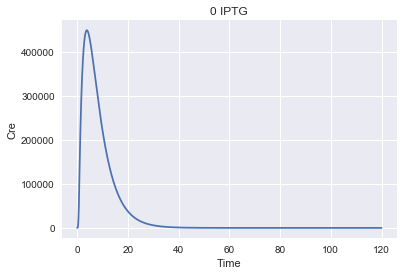

In [287]:
t  = np.linspace(0, 120, 20000) 
iex = 0

soln = odeint(f, y0, t)

mr_s = soln[:, 0]
r_s = soln[:, 1]
r2_s = soln[:, 2]
oy_s = soln[:, 3]
ot7_s = soln[:, 4]
ocre_s = soln[:, 5]
i_s = soln[:, 6]
i2r2_s = soln[:, 7]
my_s = soln[:, 8]
lac_Y_s = soln[:, 9]
mt7_s = soln[:, 10]
t7_s = soln[:, 11]
mcre_s = soln[:, 12]
cre_s = soln[:, 13]
yiex_s = soln[:, 14]


for i in range(20000):
    p_total_continuous.append(0)
    q_total_continuous.append(0)
    cre_continuous.append(cre_s[i])

    s_itself_continuous.append(0)
    s_combined_continuous.append(0)

    se_continuous.append(0)
    se2a_continuous.append(0)
    se2b_continuous.append(0)
    se3_continuous.append(0)
    se4_continuous.append(0)
    sc_continuous.append(0)

    qe2_continuous.append(0)
    qe_continuous.append(0)
    q_continuous.append(0)
    rfp_continuous.append(0)

plt.plot(t, cre_s)
plt.title('0 IPTG')
plt.ylabel('Cre')
plt.xlabel('Time') 
print("0 IPTG, Cre: ", cre_continuous[19999])

In [288]:
def f(y, t):
     mr = y[0]
     r = y[1]
     r2 = y[2]
     oy = y[3]
     ot7 = y[4]
     ocre = y[5]
     i = y[6]   
     i2r2 = y[7]
     my = y[8]
     lac_Y = y[9]
     mt7 = y[10]
     t7 = y[11]
     mcre = y[12]
     cre = y[13]   
     yiex = y[14]
     s = y[15]
     se = y[16]
     se2a = y[17]
     se2b = y[18]
     se3 = y[19]
     se4 = y[20]
     sc = y[21]
     qe2 = y[22]
     pe2 = y[23]   
     qe = y[24]
     pe = y[25]
     q = y[26]
     p = y[27]
     mrfp = y[28]
     rfp = y[29]   
    
    
     f0 = k_smr - lambda_mr*mr
     f1 = k_sr*mr - 2*k_2r*r*r + 2*k_Neg_2r*r2 - lambda_r*r
     f2 = k_2r*r*r - k_Neg_2r*r2 - k_rt7*r2*ot7 + k_Neg_rt7*(2.08-ot7) - k_ry*r2*oy + k_Neg_ry*(2.08-oy) - k_rcre*r2*ocre + k_Neg_rcre*(60-ocre) - k_dr1*i*i*r2 + k_Neg_dr1*i2r2 - lambda_r2*r2
     f3 = -k_ry*r2*oy + k_Neg_ry*(2.08-oy) + k_dr4*i*i*(2.08-oy) - k_Neg_dr4*i2r2*oy
     f4 = -k_rt7*r2*ot7 + k_Neg_rt7*(2.08-ot7) + k_dr2*i*i*(2.08-ot7) - k_Neg_dr2*i2r2*ot7
     f5 = -k_rcre*r2*ocre + k_Neg_rcre*(60-ocre) + k_dr3*i*i*(60-ocre) - k_Neg_dr3*i2r2*ocre      
     f6 = -2*k_dr1*r2*i*i + 2*k_Neg_dr1*i2r2 - 2*k_dr2*(2.08-ot7)*i*i + 2*k_Neg_dr2*ot7*i2r2 - 2*k_dr3*(60-ocre)*i*i + 2*k_Neg_dr3*ocre*i2r2 - 2*k_dr4*(2.08-oy)*i*i + 2*k_Neg_dr4*oy*i2r2 + k_ft*yiex + k_t*(iex-i) + 2*lambda_i2r2*i2r2 + lambda_yiex*yiex
     f7 = k_dr1*i*i*r2 - k_Neg_dr1*i2r2 + k_dr2*i*i*(2.08-ot7) - k_Neg_dr2*i2r2*ot7 + k_dr3*i*i*(60-ocre) - k_Neg_dr3*i2r2*ocre + k_dr4*i*i*(2.08-oy) - k_Neg_dr4*i2r2*oy - lambda_i2r2*i2r2
     f8 = k_s0my*(2.08-oy) + k_s1my*oy - lambda_my*my
     f9 = k_sy*my + (k_ft + k_Neg_p)*yiex - k_p*lac_Y*iex - lambda_y*lac_Y
     f10 = k_s0mt7*(2.08-ot7) + k_s1mt7*ot7 - lambda_mt7*mt7    
     f11 = k_st7*mt7 - lambda_t7*t7
     f12 = k_s0mcre*(60-ocre)*t7 + k_s1mcre*ocre*t7 - lambda_mcre*mcre   
     f13 = k_scre*mcre - lambda_cre*cre - k_1*s*cre + k_Neg_1*se - k_1*se*cre + k_Neg_1*se2a - k_2*se*cre + k_Neg_2*se2b -k_2*se2a*cre + k_Neg_2*se3 - k_1*se2b*cre + k_Neg_1*se3 - k_2*se3*cre + k_Neg_2*se4 + k_Neg_2*(qe2+pe2) - k_2*(qe+pe)*cre + k_Neg_1*(qe+pe) - k_1*(q+p)*cre  
     f14 = -(k_ft + k_Neg_p)*yiex + k_p*lac_Y*iex - lambda_yiex*yiex  
     f15 = -k_1*s*cre + k_Neg_1*se
     f16 = k_1*s*cre - k_Neg_1*se - (k_1 + k_2)*se*cre + k_Neg_1*se2a + k_Neg_2*se2b   
     f17 = k_1*se*cre - k_Neg_1*se2a - k_2*se2a*cre + k_Neg_2*se3
     f18 = k_2*se*cre - k_Neg_2*se2b - k_1*se2b*cre + k_Neg_1*se3
     f19 = k_2*se2a*cre - (k_Neg_2 + k_Neg_1)*se3 + k_1*se2b*cre - k_2*se3*cre + k_Neg_2*se4
     f20 = k_2*se3*cre - (k_Neg_2+k_3)*se4 + k_Neg_3*sc
     f21 = k_3*se4 - (k_Neg_3+k_Neg_4)*sc + k_4*qe2*pe2   
     f22 = k_Neg_4*sc - k_4*qe2*pe2 - k_Neg_2*qe2 + k_2*qe*cre
     f23 = k_Neg_4*sc - k_4*qe2*pe2 - k_Neg_2*pe2 + k_2*pe*cre
     f24 = k_Neg_2*qe2 - k_2*qe*cre - k_Neg_1*qe + k_1*q*cre
     f25 = k_Neg_2*pe2 - k_2*pe*cre - k_Neg_1*pe + k_1*p*cre
     f26 = k_Neg_1*qe - k_1*q*cre
     f27 = k_Neg_1*pe - k_1*p*cre
     f28 = k_mRFP*(p+pe+pe2) - lambda_mRFP*mrfp
     f29 = k_RFP*mrfp - lambda_RFP*rfp   

     return [f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, f13, f14, f15, f16, f17, f18, f19, f20, f21, f22, f23, f24, f25, f26, f27, f28, f29]


In [289]:
mr_0 = mr_s[19999]
r_0 = r_s[19999]
r2_0 = r2_s[19999]
oy_0 = oy_s[19999]
ot7_0 = ot7_s[19999]
ocre_0 = ocre_s[19999]
i_0 = i_s[19999]
i2r2_0 = i2r2_s[19999]
my_0 = my_s[19999]
lac_Y_0 = lac_Y_s[19999]
mt7_0 = mt7_s[19999]
t7_0 = t7_s[19999]
mcre_0 = mcre_s[19999]
cre_0 = cre_s[19999]
yiex_0 = yiex_s[19999]

s_0 = 100
se_0 = 0
se2a_0 = 0
se2b_0 = 0
se3_0 = 0
se4_0 = 0
sc_0 = 0
qe2_0 = 0
pe2_0 = 0 
qe_0 = 0
pe_0 = 0
q_0 = 0
p_0 = 0 
mrfp_0 = 0
rfp_0 = 0
y0 = [mr_0, r_0, r2_0, oy_0, ot7_0, ocre_0, i_0, i2r2_0, my_0, lac_Y_0, mt7_0, t7_0, mcre_0, cre_0, yiex_0, s_0, se_0, se2a_0, se2b_0, se3_0, se4_0, sc_0, qe2_0, pe2_0, qe_0, pe_0, q_0, p_0, mrfp_0, rfp_0]     

0 IPTG, RFP:  227101.438311


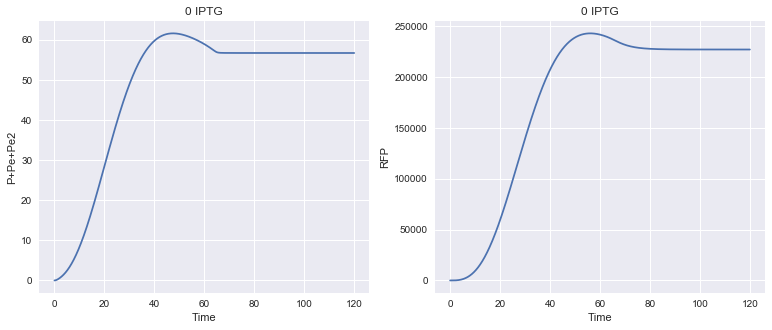

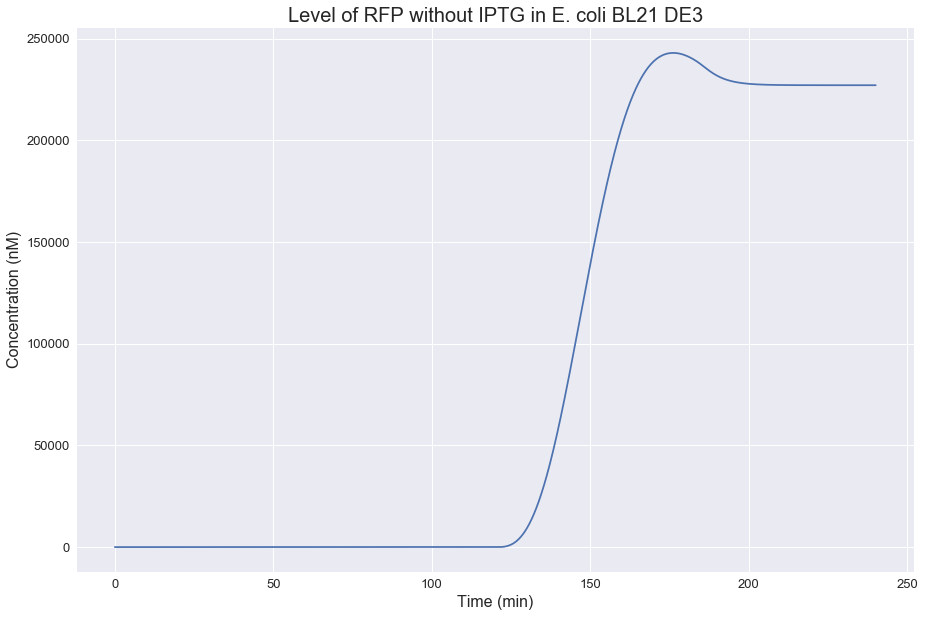

In [290]:
t  = np.linspace(0, 120, 20000) 
iex = 0

soln = odeint(f, y0, t)

mr_s = soln[:, 0]
r_s = soln[:, 1]
r2_s = soln[:, 2]
oy_s = soln[:, 3]
ot7_s = soln[:, 4]
ocre_s = soln[:, 5]
i_s = soln[:, 6]
i2r2_s = soln[:, 7]
my_s = soln[:, 8]
lac_Y_s = soln[:, 9]
mt7_s = soln[:, 10]
t7_s = soln[:, 11]
mcre_s = soln[:, 12]
cre_s = soln[:, 13]
yiex_s = soln[:, 14]
s_s = soln[:, 15]
se_s = soln[:, 16]
se2a_s = soln[:, 17]
se2b_s = soln[:, 18]
se3_s = soln[:, 19]
se4_s = soln[:, 20]
sc_s = soln[:, 21]
qe2_s = soln[:, 22]
pe2_s = soln[:, 23]
qe_s = soln[:, 24]
pe_s = soln[:, 25]
q_s = soln[:, 26]
p_s = soln[:, 27]
mrfp_s = soln[:,28]
rfp_s = soln[:,29]


plt.figure(figsize=(13,5))
plt.subplot(1, 2, 1)
plt.plot(t, p_s + pe_s + pe2_s)
plt.title('0 IPTG')
plt.ylabel('P+Pe+Pe2')
plt.xlabel('Time')

plt.subplot(1, 2, 2)
plt.plot(t, rfp_s)
plt.title('0 IPTG')
plt.ylabel('RFP')
plt.xlabel('Time')




for i in range(20000):
    p_total_continuous.append(p_s[i] + pe_s[i] + pe2_s[i])
    q_total_continuous.append(q_s[i] + qe_s[i] + qe2_s[i])
    cre_continuous.append(cre_s[i])
    
    s_itself_continuous.append(s_s[i])
    s_combined_continuous.append(se_s[i] + se2a_s[i] + se2b_s[i] + se3_s[i] + se4_s[i] + sc_s[i])

    se_continuous.append(se_s[i])
    se2a_continuous.append(se2a_s[i])
    se2b_continuous.append(se2b_s[i])
    se3_continuous.append(se3_s[i])
    se4_continuous.append(se4_s[i])
    sc_continuous.append(sc_s[i])

    qe2_continuous.append(qe2_s[i])
    qe_continuous.append(qe_s[i])
    q_continuous.append(q_s[i]) 
    rfp_continuous.append(rfp_s[i])
    
t  = np.linspace(0, 240, 40000) 
plt.figure(figsize=(15,10))
plt.plot(t, rfp_continuous)
plt.title('Level of RFP without IPTG in E. coli BL21 DE3',size=20)
plt.ylabel('Concentration (nM)',size=16)
plt.xlabel('Time (min)',size=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
print("0 IPTG, RFP: ", rfp_continuous[39999])

#plt.savefig('2) RFP without IPTG.png', dpi=300)    

In [291]:
y_e = []
for i in range(30):
    value = soln[:, i]
    y_e.append(value[19999])

iex = 800000
t  = np.linspace(0, 30, 5000) 

soln = odeint(f, y_e, t)

mr_s = soln[:, 0]
r_s = soln[:, 1]
r2_s = soln[:, 2]
oy_s = soln[:, 3]
ot7_s = soln[:, 4]
ocre_s = soln[:, 5]
i_s = soln[:, 6]
i2r2_s = soln[:, 7]
my_s = soln[:, 8]
lac_Y_s = soln[:, 9]
mt7_s = soln[:, 10]
t7_s = soln[:, 11]
mcre_s = soln[:, 12]
cre_s = soln[:, 13]
yiex_s = soln[:, 14]
s_s = soln[:, 15]
se_s = soln[:, 16]
se2a_s = soln[:, 17]
se2b_s = soln[:, 18]
se3_s = soln[:, 19]
se4_s = soln[:, 20]
sc_s = soln[:, 21]
qe2_s = soln[:, 22]
pe2_s = soln[:, 23]
qe_s = soln[:, 24]
pe_s = soln[:, 25]
q_s = soln[:, 26]
p_s = soln[:, 27]
mrfp_s = soln[:,28]
rfp_s = soln[:,29]

# plt.figure(figsize=(13,5))
# plt.subplot(1, 2, 1)
# plt.plot(t, p_s + pe_s + pe2_s)
# plt.title('100000 IPTG')
# plt.ylabel('P+Pe+Pe2')
# plt.xlabel('Time')

# plt.subplot(1, 2, 2)
# plt.plot(t, cre_s)
# plt.title('100000 IPTG')
# plt.ylabel('Cre')
# plt.xlabel('Time')

for i in range(5000):
    p_total_continuous.append(p_s[i] + pe_s[i] + pe2_s[i])
    q_total_continuous.append(q_s[i] + qe_s[i] + qe2_s[i])    
    cre_continuous.append(cre_s[i])
    
    s_itself_continuous.append(s_s[i])
    s_combined_continuous.append(se_s[i] + se2a_s[i] + se2b_s[i] + se3_s[i] + se4_s[i] + sc_s[i])

    se_continuous.append(se_s[i])
    se2a_continuous.append(se2a_s[i])
    se2b_continuous.append(se2b_s[i])
    se3_continuous.append(se3_s[i])
    se4_continuous.append(se4_s[i])
    sc_continuous.append(sc_s[i])

    qe2_continuous.append(qe2_s[i])
    qe_continuous.append(qe_s[i])
    q_continuous.append(q_s[i]) 
    rfp_continuous.append(rfp_s[i])

In [292]:
y_e2 = []
for i in range(30):
    value = soln[:, i]
    y_e2.append(value[4999])

    
t  = np.linspace(0, 120, 20000) 
iex = 0

soln = odeint(f, y_e2, t)

mr_s = soln[:, 0]
r_s = soln[:, 1]
r2_s = soln[:, 2]
oy_s = soln[:, 3]
ot7_s = soln[:, 4]
ocre_s = soln[:, 5]
i_s = soln[:, 6]
i2r2_s = soln[:, 7]
my_s = soln[:, 8]
lac_Y_s = soln[:, 9]
mt7_s = soln[:, 10]
t7_s = soln[:, 11]
mcre_s = soln[:, 12]
cre_s = soln[:, 13]
yiex_s = soln[:, 14]
s_s = soln[:, 15]
se_s = soln[:, 16]
se2a_s = soln[:, 17]
se2b_s = soln[:, 18]
se3_s = soln[:, 19]
se4_s = soln[:, 20]
sc_s = soln[:, 21]
qe2_s = soln[:, 22]
pe2_s = soln[:, 23]
qe_s = soln[:, 24]
pe_s = soln[:, 25]
q_s = soln[:, 26]
p_s = soln[:, 27]
mrfp_s = soln[:,28]
rfp_s = soln[:,29]

# plt.figure(figsize=(13,5))
# plt.subplot(1, 2, 1)
# plt.plot(t, p_s + pe_s + pe2_s)
# plt.title('0 IPTG')
# plt.ylabel('P+Pe+Pe2')
# plt.xlabel('Time')

# plt.subplot(1, 2, 2)
# plt.plot(t, cre_s)
# plt.title('0 IPTG')
# plt.ylabel('Cre')
# plt.xlabel('Time')


for i in range(20000):
    p_total_continuous.append(p_s[i] + pe_s[i] + pe2_s[i])
    q_total_continuous.append(q_s[i] + qe_s[i] + qe2_s[i])
    cre_continuous.append(cre_s[i])
    
    s_itself_continuous.append(s_s[i])
    s_combined_continuous.append(se_s[i] + se2a_s[i] + se2b_s[i] + se3_s[i] + se4_s[i] + sc_s[i])

    se_continuous.append(se_s[i])
    se2a_continuous.append(se2a_s[i])
    se2b_continuous.append(se2b_s[i])
    se3_continuous.append(se3_s[i])
    se4_continuous.append(se4_s[i])
    sc_continuous.append(sc_s[i])

    qe2_continuous.append(qe2_s[i])
    qe_continuous.append(qe_s[i])
    q_continuous.append(q_s[i]) 
    
    rfp_continuous.append(rfp_s[i])

800000 IPTG 30 min, P Total:  56.7062557745
800000 IPTG 30 min, RFP:  227101.137996


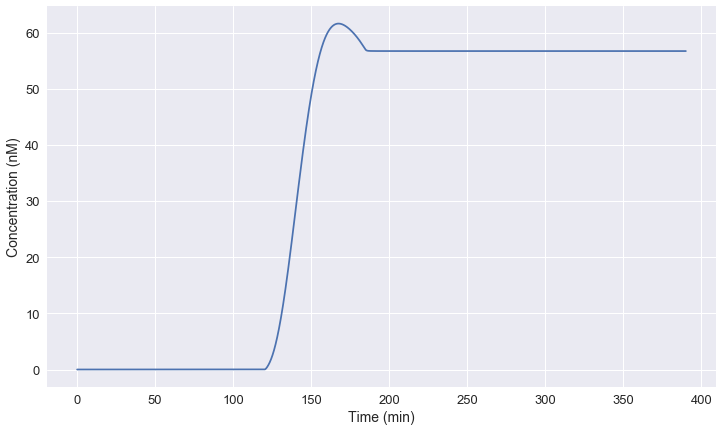

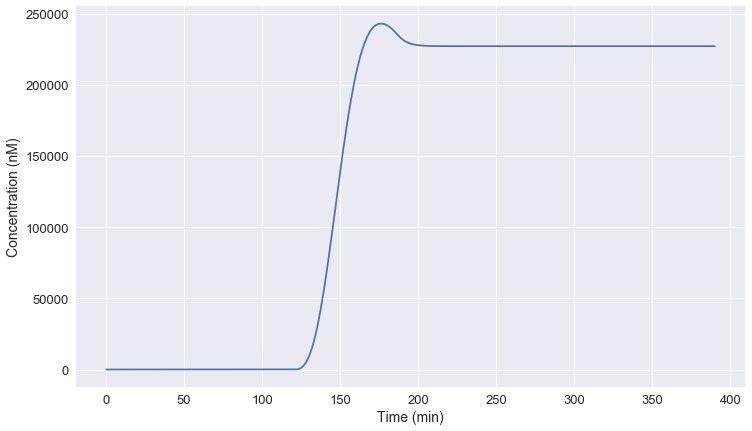

In [293]:
t  = np.linspace(0, 390, 65000) 

plt.figure(figsize=(12,7))
plt.plot(t, p_total_continuous)
plt.ylabel('Concentration (nM)',size=14)
plt.xlabel('Time (min)',size=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig('3) P+PE+PE2 800000 IPTG 30 min.png', dpi=300)

plt.figure(figsize=(12,7))
plt.plot(t, rfp_continuous)
plt.ylabel('Concentration (nM)',size=14)
plt.xlabel('Time (min)',size=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig('3) RFP 800000 IPTG 30 min.png', dpi=300)

print("800000 IPTG 30 min, P Total: ", p_total_continuous[64999])
print("800000 IPTG 30 min, RFP: ", rfp_continuous[64999])